SARIMA: Моделирование сезонности
Если в ряде есть сезонность (повторяющиеся паттерны с фиксированным периодом — месяц, квартал, год), обычная ARIMA не справится. Нужен SARIMA.

SARIMA(p,d,q)(P,D,Q,s) — это ARIMA с сезонной компонентой.

(p,d,q) — несезонные параметры (как в обычной ARIMA).

(P,D,Q) — сезонные параметры (аналогичны p,d,q, но для сезонных лагов).

s — период сезонности (например, 12 для месячных данных с годовой сезонностью).

Простыми словами: SARIMA — это две модели в одной:

Обычная ARIMA для несезонной части (тренд, краткосрочная память).

Сезонная ARIMA для паттернов, которые повторяются каждый s периодов.

Пример: SARIMA(1,1,1)(1,1,1,12) для месячных данных означает:

(1,1,1) — берем первые разности, учитываем один несезонный лаг AR и один несезонный лаг MA.

(1,1,1,12) — берем сезонные разности 12-го порядка (Y_t - Y_{t-12}), учитываем один сезонный лаг AR(12) и один сезонный лаг MA(12).

Сезонные разности — ключевое преобразование. D=1 со s=12 означает, что мы моделируем не "уровень воды в январе", а "изменение уровня воды по сравнению с январем прошлого года". Это убивает сезонность так же, как обычные разности убивают тренд.



Практика: Анализ ряда с сезонностью

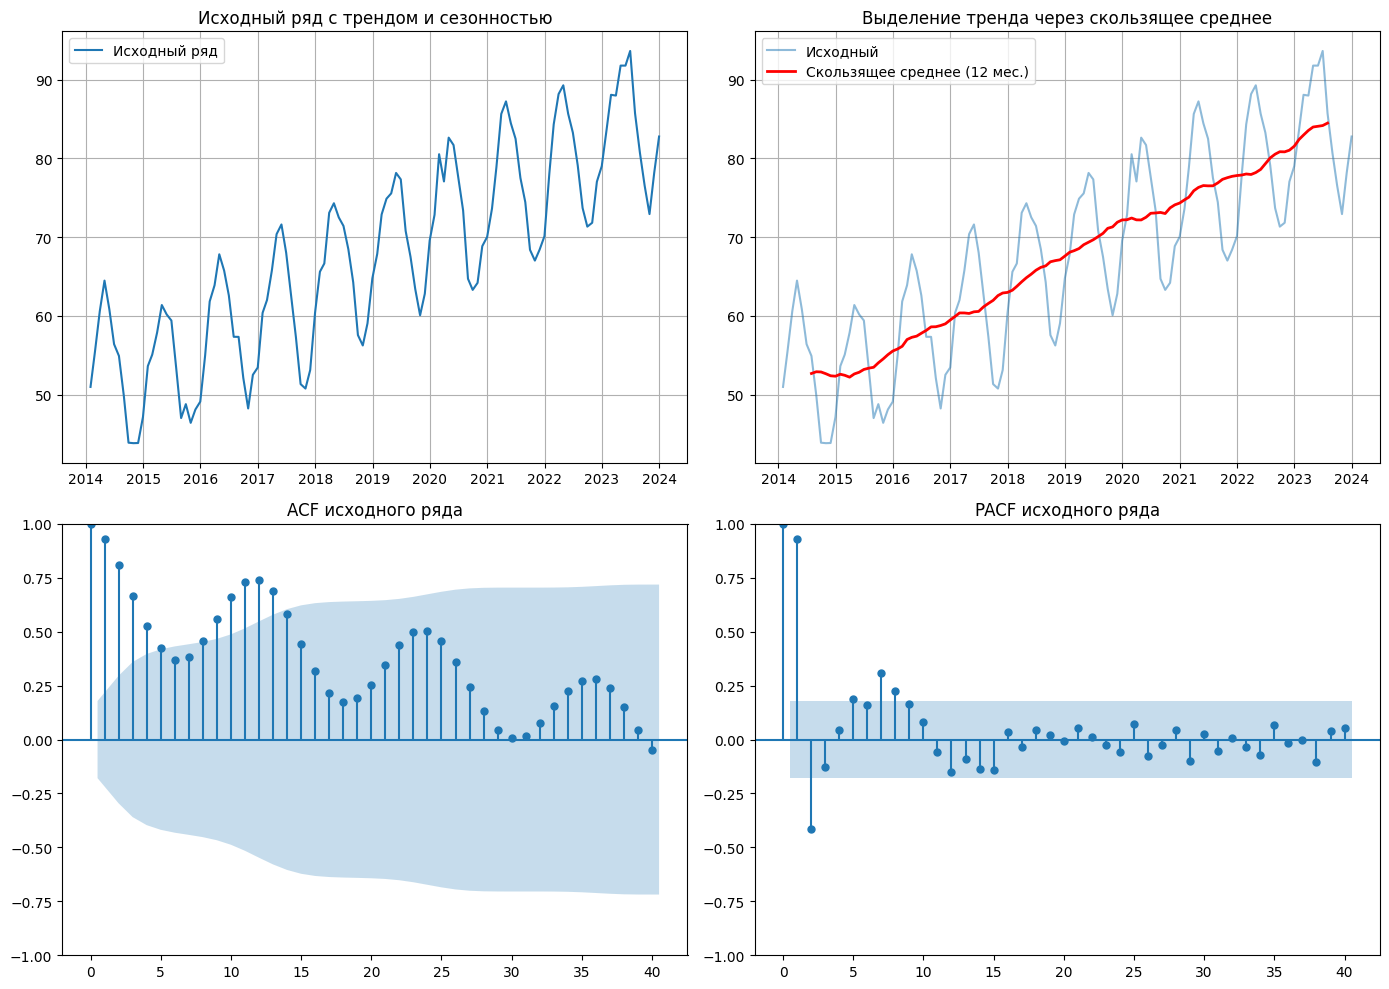

=== Тест Дики-Фуллера ===
ADF: 0.724, p-value: 0.9903
Стационарен: False


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. Генерация ряда с трендом и СЕЗОННОСТЬЮ (s=12)
np.random.seed(42)
n = 120  # 10 лет месячных данных
time = pd.date_range(start='2014-01-01', periods=n, freq='ME')

# Компоненты: тренд + сезонность + шум + AR-компонента
trend = 0.3 * np.arange(n)
seasonality = 10 * np.sin(2 * np.pi * np.arange(n) / 12)  # Годовая сезонность
noise = np.random.normal(0, 2, n)

# Создаем базовый ряд
y = 50 + trend + seasonality + noise

# Добавляем автокорреляцию (память)
for t in range(1, n):
    y[t] = y[t] + 0.4 * (y[t-1] - (50 + trend[t-1] + seasonality[t-1]))

series = pd.Series(y, index=time, name='sales')

# 2. Визуализация
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Исходный ряд
axes[0, 0].plot(series, label='Исходный ряд')
axes[0, 0].set_title('Исходный ряд с трендом и сезонностью')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Сезонная декомпозиция (грубая, через скользящее среднее)
window = 12
rolling_mean = series.rolling(window=window, center=True).mean()
axes[0, 1].plot(series, alpha=0.5, label='Исходный')
axes[0, 1].plot(rolling_mean, 'r', linewidth=2, label=f'Скользящее среднее ({window} мес.)')
axes[0, 1].set_title('Выделение тренда через скользящее среднее')
axes[0, 1].legend()
axes[0, 1].grid(True)

# ACF исходного ряда (видна сезонность!)
plot_acf(series, lags=40, ax=axes[1, 0], title='ACF исходного ряда')
# PACF исходного ряда
plot_pacf(series, lags=40, ax=axes[1, 1], title='PACF исходного ряда', method='ywm')

plt.tight_layout()
plt.show()

# 3. Проверка стационарности
print("=== Тест Дики-Фуллера ===")
result = adfuller(series.dropna())
print(f'ADF: {result[0]:.3f}, p-value: {result[1]:.4f}')
print(f'Стационарен: {result[1] < 0.05}')

Что видим:

На ACF — пики на лагах 12, 24, 36 — явный признак сезонности с периодом 12.

Ряд нестационарен (есть тренд + сезонность).



Преобразование: как убрать сезонность

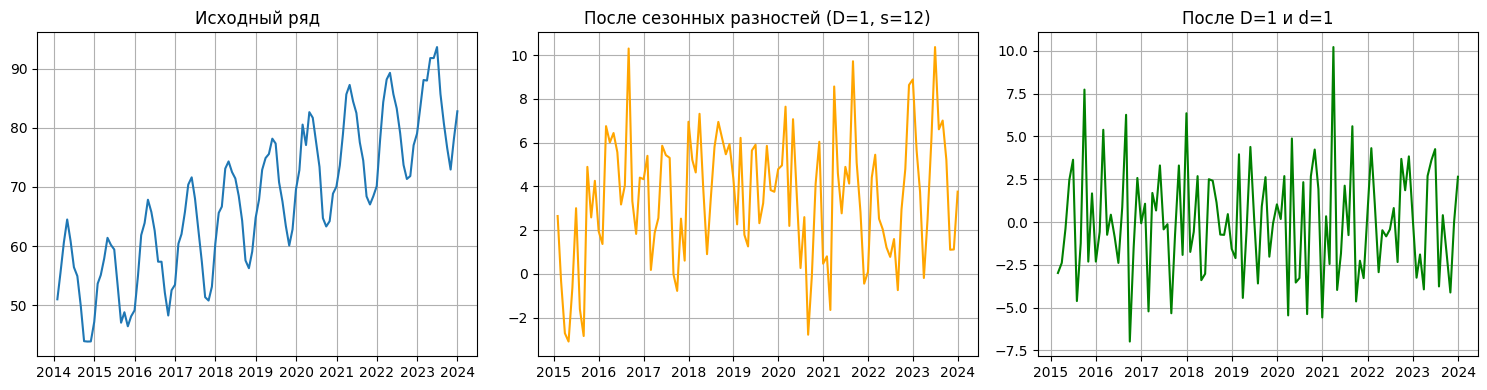


=== После преобразований ===
Сезонные разности: True
Сезонные + первые разности: True


In [12]:
# 4. Сезонные разности (D=1, s=12)
series_seasonal_diff = series.diff(periods=12).dropna()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Исходный ряд
axes[0].plot(series, label='Исходный')
axes[0].set_title('Исходный ряд')
axes[0].grid(True)

# Сезонные разности (после вычитания значения 12 месяцев назад)
axes[1].plot(series_seasonal_diff, color='orange', label='Сезонные разности (lag=12)')
axes[1].set_title('После сезонных разностей (D=1, s=12)')
axes[1].grid(True)

# Обычные первые разности после сезонных
series_seasonal_trend_diff = series_seasonal_diff.diff().dropna()
axes[2].plot(series_seasonal_trend_diff, color='green', label='Сезонные + первые разности')
axes[2].set_title('После D=1 и d=1')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Проверка стационарности после преобразований
print("\n=== После преобразований ===")
print("Сезонные разности:", adfuller(series_seasonal_diff)[1] < 0.05)
print("Сезонные + первые разности:", adfuller(series_seasonal_trend_diff)[1] < 0.05)

Подбор и построение SARIMA


=== Сравнение моделей ===
SARIMA(0,1,1)(0,1,1,12) - AIC: 478.8
SARIMA(1,1,1)(0,1,1,12) - AIC: 478.8
SARIMA(1,1,1)(1,1,1,12) - AIC: 472.7


C:\Users\nikis\PycharmProjects\JupyterProject3\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


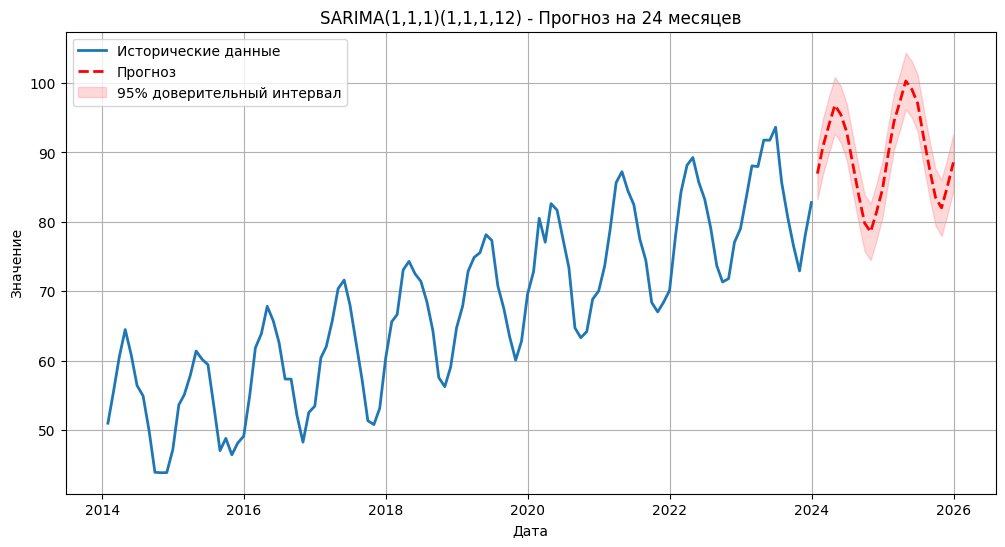


=== Диагностика остатков лучшей модели ===


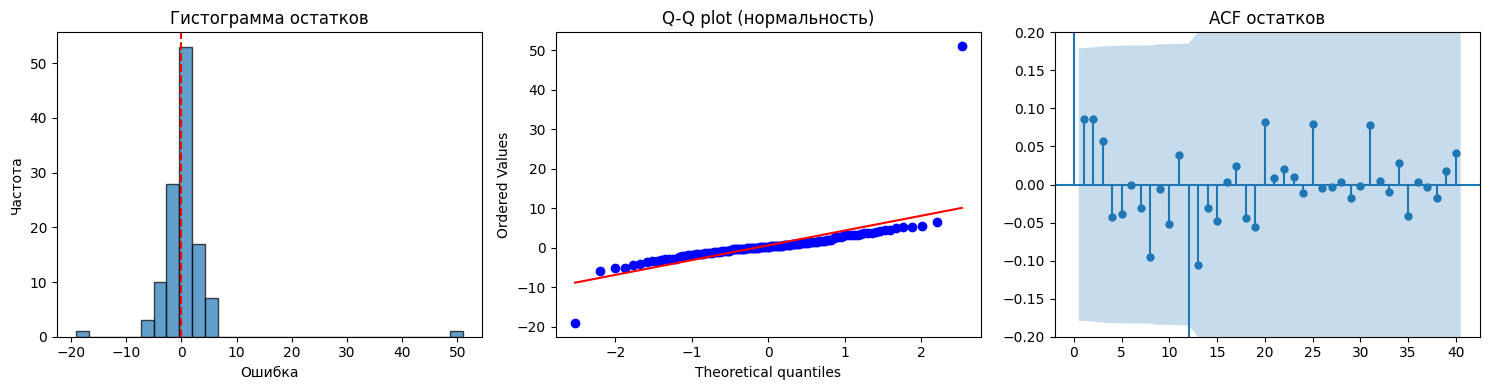


Тест Льюнга-Бокса (H0: нет автокорреляции):
p-value = 0.9319
Остатки не коррелированы


In [13]:
# 5. Построение SARIMA моделей
print("\n=== Сравнение моделей ===")

# Модель 1: Только сезонная компонента
model1 = SARIMAX(series, order=(0,1,1), seasonal_order=(0,1,1,12),
                simple_differencing=False)
res1 = model1.fit(disp=False)
print(f"SARIMA(0,1,1)(0,1,1,12) - AIC: {res1.aic:.1f}")

# Модель 2: Сезонная + несезонная AR компонента
model2 = SARIMAX(series, order=(1,1,1), seasonal_order=(0,1,1,12),
                simple_differencing=False)
res2 = model2.fit(disp=False)
print(f"SARIMA(1,1,1)(0,1,1,12) - AIC: {res1.aic:.1f}")

# Модель 3: Полная модель
model3 = SARIMAX(series, order=(1,1,1), seasonal_order=(1,1,1,12),
                simple_differencing=False)
res3 = model3.fit(disp=False)
print(f"SARIMA(1,1,1)(1,1,1,12) - AIC: {res3.aic:.1f}")

# 6. Прогноз лучшей моделью
best_model = res3  # выбрали модель с наименьшим AIC
forecast_steps = 24
forecast = best_model.get_forecast(steps=forecast_steps)

# Визуализация прогноза
fig, ax = plt.subplots(figsize=(12, 6))

# Исторические данные
ax.plot(series.index, series.values, label='Исторические данные', linewidth=2)

# Прогноз
forecast_index = pd.date_range(start=series.index[-1], periods=forecast_steps+1, freq='ME')[1:]
ax.plot(forecast_index, forecast.predicted_mean.values,
        label='Прогноз', color='red', linestyle='--', linewidth=2)

# Доверительный интервал
ax.fill_between(forecast_index,
                forecast.conf_int()['lower sales'].values,
                forecast.conf_int()['upper sales'].values,
                color='red', alpha=0.15, label='95% доверительный интервал')

ax.set_title(f'SARIMA(1,1,1)(1,1,1,12) - Прогноз на {forecast_steps} месяцев')
ax.set_xlabel('Дата')
ax.set_ylabel('Значение')
ax.legend()
ax.grid(True)
plt.show()

# 7. Диагностика остатков
print("\n=== Диагностика остатков лучшей модели ===")
residuals = best_model.resid

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Распределение остатков
axes[0].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Гистограмма остатков')
axes[0].set_xlabel('Ошибка')
axes[0].set_ylabel('Частота')
axes[0].axvline(x=0, color='r', linestyle='--')

# Q-Q plot (проверка нормальности)
from scipy import stats
stats.probplot(residuals.dropna(), dist="norm", plot=axes[1])
axes[1].set_title('Q-Q plot (нормальность)')

# ACF остатков
plot_acf(residuals.dropna(), lags=40, ax=axes[2], title='ACF остатков')
axes[2].set_ylim(-0.2, 0.2)

plt.tight_layout()
plt.show()

# Тест Льюнга-Бокса на автокорреляцию остатков
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuals.dropna(), lags=[10], return_df=True)
print(f"\nТест Льюнга-Бокса (H0: нет автокорреляции):")
print(f"p-value = {lb_test['lb_pvalue'].values[0]:.4f}")
print("Остатки не коррелированы" if lb_test['lb_pvalue'].values[0] > 0.05
      else "Есть автокорреляция в остатках")

Выводы:Сезонность видна на ACF — повторяющиеся пики через каждый s лагов.

Сезонные разности (Y_t - Y_{t-s}) — то же, что обычные разности для тренда, только для сезонности.

SARIMA = ARIMA × Сезонная ARIMA — параметров в 2 раза больше, но логика та же.

Порядок преобразований:

Сначала сезонные разности (D=1, s=12), чтобы убрать сезонность

Потом обычные разности (d=1), чтобы убрать тренд

Анализируем ACF/PACF стационарного ряда для подбора p,q,P,Q

Проверка остатков критична — если в них осталась сезонность, нужно увеличить D или Q.

На практике: Для месячных данных часто работают модели вида (p,d,q)(P,D,Q,12) где D=1 (сезонные разности), а P,Q редко бывают больше 1



Задание

У вас есть ежемесячные данные о продажах горячих напитков (кофе/чай) за 5 лет (60 наблюдений). Данные содержат:

Явную годовую сезонность (рост продаж зимой, спад летом)

Положительный тренд

Эффект праздников (пики в декабре)



Часть 1: Разведочный анализ и стационарность
Загрузите данные и постройте график ряда. Визуально определите:

Наличие тренда

Период сезонности

Аномалии/выбросы

Проведите сезонную декомпозицию (аддитивную или мультипликативную — обоснуйте выбор).

Проверьте ряд на стационарность тестом Дики-Фуллера. Сделайте вывод.

Часть 2: Преобразования и идентификация модели
Выполните преобразования для стационарности:

Сначала сезонные разности (s=12)

Затем обычные первые разности
Проверьте стационарность после каждого шага.

Постройте ACF и PACF для преобразованного стационарного ряда. Ответьте:

На каких лагах видны сезонные автокорреляции?

Какие параметры p, q, P, Q можно предположить?

Часть 3: Построение и сравнение моделей SARIMA
Постройте три модели SARIMA с разными параметрами:

Модель 1: (0,1,1)(0,1,1,12) — базовая

Модель 2: (1,1,1)(0,1,1,12) — с несезонной AR

Модель 3: Ваш вариант на основе ACF/PACF анализа

Для каждой модели:

Выведите summary()

Запишите значение AIC

Постройте график остатков

Проведите тест Льюнга-Бокса на автокорреляцию остатков

Сравните модели по AIC и качеству остатков. Выберите лучшую.

Часть 4: Прогноз и интерпретация
Сделайте прогноз на 12 месяцев (год вперёд) по лучшей модели.

Визуализируйте:

Исторические данные

Точечный прогноз

95% доверительный интервал

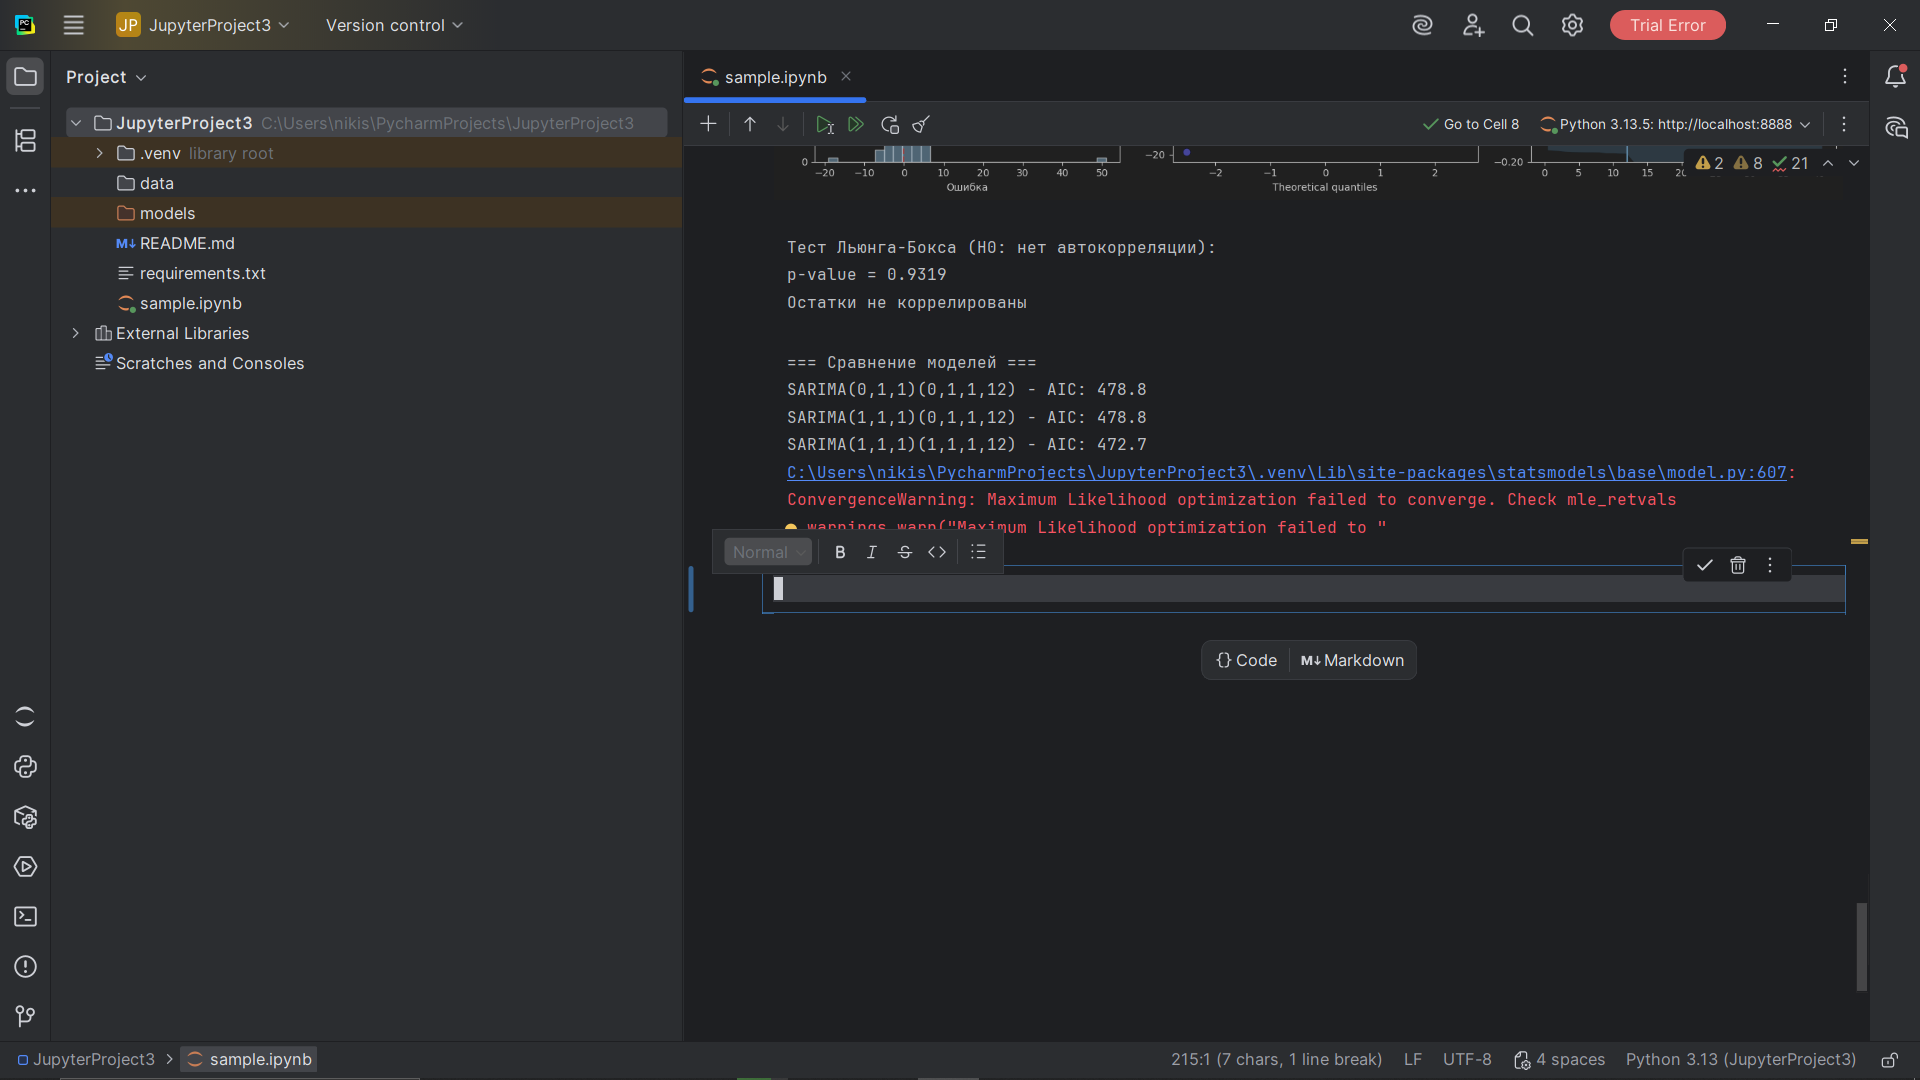